In [1]:
# Import common packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import the files and read them using pandas. Save them in a dictionary of pandas dataframes, for the different patients
import sys, os
path = "./data/"

activities = {}
levels = {}

for directory in os.listdir(path):
    for file in os.listdir(f"{path}/{directory}"):
        if file[:10] == "activities":
            activities[directory[:1]] = pd.read_csv(f"{path}/{directory}/{file}", header=0)
        elif file[:6] == "levels":
            levels[directory[:1]] = pd.read_csv(f"{path}/{directory}/{file}", header=1)

In [3]:
# Print number of variables for each column, to check which ones are relevant
patient = "a"
levels[patient].count()

Gerät                                          1199
Seriennummer                                   1199
Gerätezeitstempel                              1199
Aufzeichnungstyp                               1199
Glukosewert-Verlauf mg/dL                      1022
Glukose-Scan mg/dL                              163
Nicht numerisches schnellwirkendes Insulin        0
Schnellwirkendes Insulin (Einheiten)              0
Nicht numerische Nahrungsdaten                    0
Kohlenhydrate (Gramm)                             0
Kohlenhydrate (Portionen)                         0
Nicht numerisches Depotinsulin                    0
Depotinsulin (Einheiten)                          0
Notizen                                           0
Glukose-Teststreifen mg/dL                        0
Keton mmol/L                                      0
Mahlzeiteninsulin (Einheiten)                     0
Korrekturinsulin (Einheiten)                      0
Insulin-Änderung durch Anwender (Einheiten)       0
dtype: int64

---
Let's create a new dataset containing the glucose features.
This is inefficient in terms of memory, but allows us to have a "raw" version of the data 

In [4]:
patients = ["a", "b", "c"]

glucose = {}

for patient in patients:
    # Filter the data having measure of type 0 or 1, and rename both measurements to Glukose-Scan mg/dL
    Measures_type_0 = levels[patient][["Gerätezeitstempel", "Glukosewert-Verlauf mg/dL", "Aufzeichnungstyp"]][levels[patient]["Aufzeichnungstyp"] == 0]
    Measures_type_0 = Measures_type_0.rename(columns = { "Glukosewert-Verlauf mg/dL": "Glukosewert mg/dL" })
    Measures_type_1 = levels[patient][["Gerätezeitstempel", "Glukose-Scan mg/dL", "Aufzeichnungstyp"]][levels[patient]["Aufzeichnungstyp"] == 1]
    Measures_type_1 = Measures_type_1.rename(columns = { "Glukose-Scan mg/dL": "Glukosewert mg/dL" })
                           
    glucose_measures = pd.concat([Measures_type_0, Measures_type_1])
    
    # Convert the UTC time into a timestamp (integer)
    glucose_measures["Gerätezeitstempel"] = pd.to_datetime(glucose_measures["Gerätezeitstempel"])
    # Convert from ns to seconds
    glucose_measures["timestamp"] = glucose_measures["Gerätezeitstempel"].values.astype(np.int64) // 10 ** 9
    
    # Add to the glucose dictionary
    glucose[patient] = glucose_measures

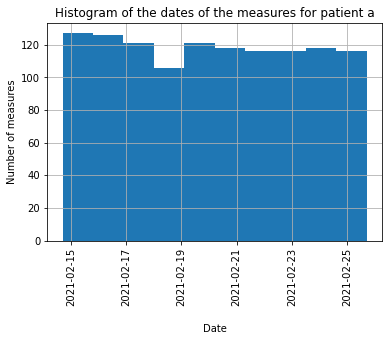

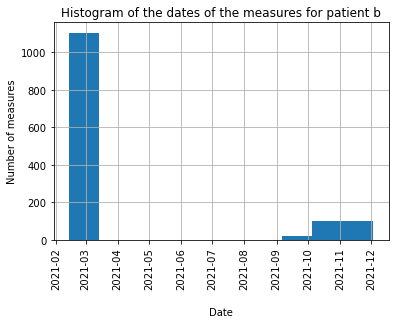

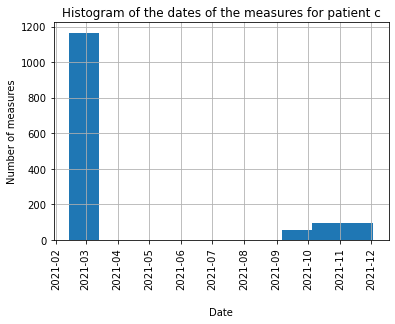

In [5]:
for patient in ["a", "b", "c"]:
    plot = glucose[patient]["Gerätezeitstempel"].hist(xrot=90)
    plot.set_xlabel("Date", labelpad=18)
    plot.set_ylabel("Number of measures")
    plot.set_title(f"Histogram of the dates of the measures for patient {patient}")
    plt.show()

The full history of glucose measures for patient "a" is continuous. However, for patients "b" and "c" the full history of the glucose measures does not give much information, since the days of samplings are sparse, and there are lots of measures in each measure day (one every 15 minutes at least). One should define an appropiate slicing function for plotting the data, so as to look at relevant slices.

However, in all cases it can give an intuition on the variance and range of the glucose measures for the patient.

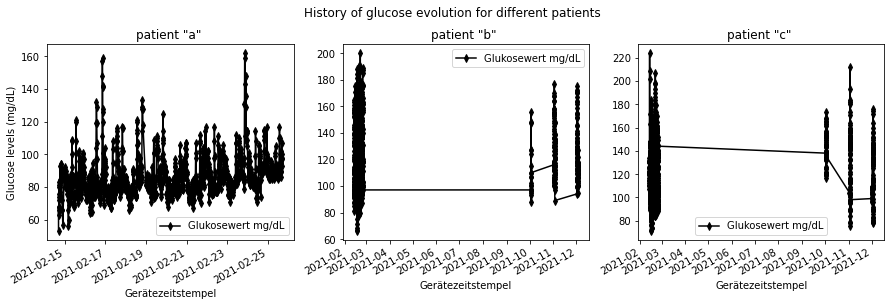

In [6]:
fig, axes = plt.subplots(figsize=(15,4),nrows=1, ncols=3)
axes[0].set_ylabel("Glucose levels (mg/dL)")
fig.suptitle("History of glucose evolution for different patients", y=1.01)

for idx, patient in enumerate(["a", "b", "c"]):
    ax = axes[idx]
    plot = glucose[patient].plot(x="Gerätezeitstempel", y="Glukosewert mg/dL", marker="d", markersize=5, c="k", ax=ax)
    ax.set_title(f"patient \"{patient}\" ")
plt.show()

In [7]:
def get_sliced_data(dataframe, initial_timestamp=None, length_minutes=180):
    
    """
    :dataframe: pandas dataframe
    :initial_timestamp: initial timestamp from the plot, in seconds
    :length_minutes: time interval to plot, starting at initial_timestamp
    """
    
    column_names = dataframe.keys()
    if "timestamp" not in column_names:
        print(f"No `datatime´ column found on the dataset. It would be retrieved from `Gerätezeitstempel´")
        assert "Gerätezeitstempel" in column_names, "The time column of the dataset could not be found"
        
        dataframe["Gerätezeitstempel"] = pd.to_datetime(dataset["Gerätezeitstempel"])
        dataframe["timestamp"] = dataframe["Gerätezeitstempel"].values.astype(np.int64) // 10 ** 9
        
    length_seconds = length_minutes * 60
    
    if initial_timestamp == None:
        initial_timestamp = dataframe["timestamp"].min(axis=0)
        
    dataframe = dataframe[(dataframe["timestamp"]<=initial_timestamp + length_seconds)&(dataframe["timestamp"] >= initial_timestamp)]
    
    return dataframe

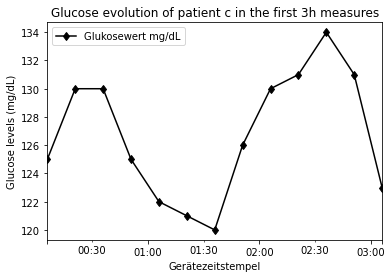

In [8]:
# Trial plot
sliced_data = get_sliced_data(glucose[patient])
plot = sliced_data.plot(x="Gerätezeitstempel", y="Glukosewert mg/dL", marker="d", c="k")
plt.title(f"Glucose evolution of patient {patient} in the first 3h measures")
plt.ylabel("Glucose levels (mg/dL)")
plt.show()

In order to avoid calling exernal libraries for converting between UTC time and timestamp, we define the starting time as a difference (in minutes) from the first timestamp.
This could be improved, but does the job in this case.

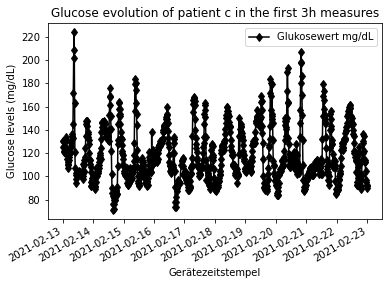

In [9]:
# Trial plot
sliced_data = get_sliced_data(glucose[patient], length_minutes=60*24*10)
plot = sliced_data.plot(x="Gerätezeitstempel", y="Glukosewert mg/dL", marker="d", c="k")
plt.title(f"Glucose evolution of patient {patient} in the first 3h measures")
plt.ylabel("Glucose levels (mg/dL)")
plt.show()

The number of data does not seem not sufficient to separate the meals between record_type (breakfast, lunch, snack, ...) and specially the description. Moreover, in this case we avoid using timestamp_end, although could give additional information (again, the number of data here is small, and no models could be tested, since they would be statistically irrelevant). 

Therefore I decide to retrieve only the timestamp_start, and also the record_type, which I may not use in the analysis.

In [10]:
patients = ["a", "b", "c"]

meals = {}

for patient in patients:
    
    meals_patient = pd.DataFrame(activities[patient][["id", "record_type", "timestamp_start"]])
    meals_patient["timestamp_start"] = pd.to_datetime(meals_patient["timestamp_start"])
    meals_patient["timestamp"] = meals_patient["timestamp_start"].values.astype(np.int64) // 10 ** 9
    
    meals[patient] = meals_patient

In [11]:
# Select only the meals (not other activities / drinks)

meals_only = {}

for patient in patients:
    meals_only[patient] = meals[patient][meals[patient]["record_type"].str[:4] == "MEAL"]
    
meals_only["a"]

id     record_type  \
0   aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa00  MEAL_BREAKFAST   
1   aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa01      MEAL_LUNCH   
2   aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa02      MEAL_SNACK   
4   aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa04     MEAL_DINNER   
5   aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa05  MEAL_BREAKFAST   
7   aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa07      MEAL_LUNCH   
9   aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa09     MEAL_DINNER   
10  aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa10  MEAL_BREAKFAST   
11  aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa11      MEAL_LUNCH   
12  aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa12      MEAL_SNACK   
13  aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaa13     MEAL_DINNER   

             timestamp_start   timestamp  
0  2021-02-15 08:30:00+01:00  1613374200  
1  2021-02-15 12:45:00+01:00  1613389500  
2  2021-02-15 16:15:00+01:00  1613402100  
4  2021-02-15 19:30:00+01:00  1613413800  
5  2021-02-17 08:15:00+01:00  1613546100  
7  2021-02-17 12:15:00+01:00  1613560500  
9  2021-02-17 19:30:00+01:00  1613586600  
10 2021-02-19 08:30:00+01:00  1613719800  
11 2021-02-19 12:00:00+01:00  1613732400  
12 2021-02-19 15:45:00+01:00  1613745900  
13 2021-02-19 19:00:00+01:00  1613757600

---

Now it's time to create the plots of the slices, beggining at the meal times. In this case, for each meal, we have an array of glucose measures. This is possible to do in pandas, but I decide to do it in numpy since it's easier to play around with the dimensions.

It is important to note that for each meals there may be a different number of glucose levels. Therefore it is not possible to construct a numpy array containing all the data (without padding).

In [12]:
meal_times = {}

for patient in patients:
    meal_times[patient] = meals_only[patient]["timestamp"].to_numpy()

# One could use the previous loop to do the following, which would be more efficient
# I however prefer readability in this case

glucose_after_meals = {}

length_seconds = 60*60*3 # 3 hours

for patient in patients:
    glucose_levels_all_arrays = []
    
    for idx, meal_time in enumerate(meal_times[patient]):
        glucose_levels = glucose[patient][(glucose[patient]["timestamp"]-meal_time<=length_seconds)&(glucose[patient]["timestamp"] >= meal_time)]
        glucose_levels = pd.DataFrame(glucose_levels)
        
        glucose_levels["time from meal"] = glucose[patient]["timestamp"] - meal_time
        glucose_levels_all_arrays.append(glucose_levels[["time from meal", "Glukosewert mg/dL"]].sort_values("time from meal"))
        
    glucose_after_meals[patient]= glucose_levels_all_arrays

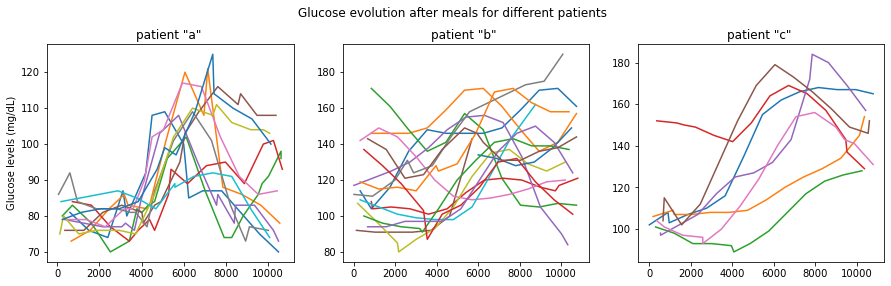

In [13]:
fig, axes = plt.subplots(figsize=(15,4),nrows=1, ncols=3)
axes[0].set_ylabel("Glucose levels (mg/dL)")
fig.suptitle("Glucose evolution after meals for different patients", y=1.01)

for idx, patient in enumerate(["a", "b", "c"]):
    ax = axes[idx]
    for i in range(len(glucose_after_meals[patient])):
        x =  glucose_after_meals[patient][i]["time from meal"].to_numpy()
        y =  glucose_after_meals[patient][i]["Glukosewert mg/dL"].to_numpy()
        ax.plot(x,y)
    ax.set_title(f"patient \"{patient}\" ")
plt.show()

It seems that the the glucose levels for the three patients have different behaviours:
- For patient "a", all meals seem to increase the glucose levels almost instantely, and decrease "quickly". The glucose levels also seem to be lower than those of the other patients.
- For patient "b", the glucose levels decrease a after the meal, then increase, and then decrease slowly.
- For patient "c", the glucose levels seem to increase instantly, but slowly and more smoothly than those of patient "a".

---

The representation of the data presented before is well-suited for evaluating the overall performance by a human, but it is not appropiate for clustering. Some of the main problems are:
- The number of datapoints for each curve may vary, thus it is not possible to compare them directly.
- The different datapoints in each curve have a temporal relation, and are not independend one from another
- The amount of curves in this dataset is small. Having a big feature dimension would most likely make most of the models overfit to the training data.

Having few amount of data, as in this case, makes difficult to use machine learning or statistical models to approximate the curves.
One could make an a priori estimation of the shapes of the curves. For example, a beta distribution seems reasonable (although it may not be applicable to patient "b", since lots of the curves start decreasing. However, any model of the distribution generating this curves would not have a statistical guarantee in this case, since we lack of data.

Therefore a good approach seems to be generating hashes for each curve, containing some information about the curve:
- What is the peak of the glucose after the meal? This could be approximated by the maximum of the array. However, the measures are not taking continuously but rather every 15 minutes. It would be better to make an interpolation or regression and then take the maximum. I do not take this approach, again, because I don't want to make assumptions on the distribution of the curves.
- When is the peak of the glucose after the meal? This would give an estimation of how slowly that meal increased the glucose levels. There may be better ways of getting that, but this is an easy way of doing it.
- The maximum increase in the glucose levels. The maximum minus the minimum value of the glucose in that frame time.

Other measures that may help, but I don't implement (mainly for time reasons) are:

- The number of local minima / maxima in the array. This would give information about the oscillations, like if first there is a decreasing on the glucose levels and then an increase, etc. However, there may be local minima/maxima due to "noise". Again, this would be solved by an intelligent regression of the data to some distribution of the curves. However, we see that for example in patient "a" there are lots of oscillations that are not representative of the overall behaviour of each curve. There are multiple ways of tackling this, but for time reasons I restrict to not use this measure.
- How "wide" is the curve around the maximum. That is, a measure of how long the patient stays with high glucose levels.

In [14]:
hashes = {}

# This code is highly inefficient. Loops could be easily avoided

for idx, patient in enumerate(["a", "b", "c"]):
    
    hashes_patient = []
    for i in range(len(glucose_after_meals[patient])):
        x =  glucose_after_meals[patient][i]["time from meal"].to_numpy()
        y =  glucose_after_meals[patient][i]["Glukosewert mg/dL"].to_numpy()
        
        feature_1 = np.max(y)
        feature_2 = x[np.argmax(x)]
        feature_3 = np.max(y) - np.min(y)
        
        hashes_patient.append([feature_1, feature_2, feature_3])
    hashes[patient] = np.array(hashes_patient)

Patient "a" 


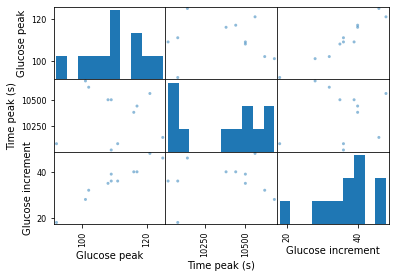

Patient "b" 


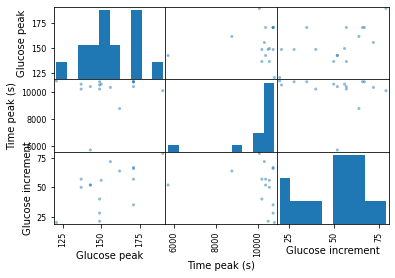

Patient "c" 


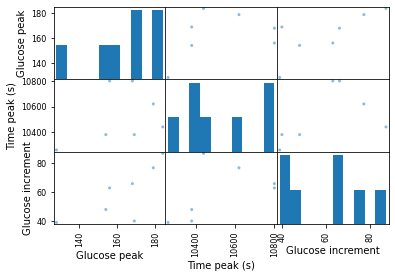

In [15]:
for patient in ["a", "b", "c"]:
    print(f"Patient \"{patient}\" ")
    df = pd.DataFrame(hashes[patient], columns = ["Glucose peak", "Time peak (s)", "Glucose increment"])
    plot = pd.plotting.scatter_matrix(df)
    plt.show()

Once an efficient and effective representation is found, and given enough data, it may be possible to cluster / classify it using methods such as K-means clustering. 
However, for this case, the number of data available make difficult to draw conclusions / use the data to train a machine learning model.